## Complete Data Pipeline: Download, Exploration, and Processing

This notebook handles the complete data preparation pipeline:

1. **Data Download** - Download enzyme sequences from UniProt
2. **Data Cleaning & Validation** - Clean missing values, validate EC numbers and sequences
3. **Exploratory Analysis** - Generate statistics and visualizations
4. **Class Balancing** - Balance dataset according to configuration
5. **Train/Val/Test Split** - Create stratified splits (70/15/15)
6. **Tokenization** - Tokenize sequences for model training

After running this notebook, you should have:
- `data/raw/uniprot_raw.csv` - Raw downloaded data
- `data/raw/uniprot_cleaned.csv` - Cleaned and validated data
- `data/processed/train.csv`, `val.csv`, `test.csv` - Split datasets
- `data/tokenized/train_dataset/`, `val_dataset/`, `test_dataset/` - Tokenized datasets

### Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import re
import yaml
import requests
import os
from io import BytesIO
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from datasets import Dataset

## 1. Data Download from UniProt

In [ ]:
# Load config file
with open("../config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# Extract configuration values
query_url = cfg["data"]["query_url"]
targets = cfg["data"]["targets"]
random_seed = cfg["project"]["random_seed"]

print("Configuration loaded:")
print(f"Query URL: {query_url}")
print(f"Random seed: {random_seed}")
print(f"\nData paths:")
print(f"  Raw: {cfg['data']['paths']['raw']}")
print(f"  Processed: {cfg['data']['paths']['processed']}")
print(f"  Tokenized: {cfg['data']['paths']['tokenized']}")


=== LOADING CONFIGURATION ===

Query URL: https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession%2Csequence%2Cec&format=tsv&query=%28reviewed%3Atrue+AND+ec%3A*+AND+length%3A%5B50+TO+1000%5D%29+AND+%28reviewed%3Atrue%29
Random seed: 42

Data paths:
  Raw: data/raw
  Processed: data/processed
  Tokenized: data/tokenized


In [4]:
# Download from UniProt
print("\nDownloading data from UniProt...")
response = requests.get(query_url)
bio = BytesIO(response.content)

# Load raw data
raw_dir = f"../{cfg['data']['paths']['raw']}"
os.makedirs(raw_dir, exist_ok=True)

df = pd.read_csv(bio, compression='gzip', sep='\t')
df = df.dropna() 

raw_file = f"{raw_dir}/uniprot_raw.csv"
df.to_csv(raw_file, index=False)

print(f"Downloaded {len(df):,} entries")
print(f"Saved to: {raw_file}")
df.head(3)


Downloaded 268,376 entries
Saved to: ../data/raw/uniprot_raw.csv


Entry                                           Sequence  \
0  A0A009IHW8  MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...   
1  A0A023I7E1  MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...   
2  A0A024RXP8  MYRKLAVISAFLATARAQSACTLQSETHPPLTWQKCSSGGTCTQQT...   

          EC number  
0  3.2.2.-; 3.2.2.6  
1          3.2.1.39  
2          3.2.1.91

## 2. Data Cleaning & Validation

In [5]:
def clean_missing_values(df):
    """Check for different types of missing values and remove them"""
    missing_indicators = ['', 'NaN', 'nan', 'None', 'NULL', np.nan]

    # Replace various missing indicators with NaN
    for indicator in missing_indicators:
        df.replace(indicator, np.nan, inplace=True)
    
    # Remove rows with missing EC Numbers (target variable)
    df_clean = df.dropna(subset=['EC number']).copy()
    
    # For sequences, either remove or impute (rare case)
    df_clean = df_clean.dropna(subset=['Sequence'])
    
    print(f"Original shape: {df.shape}")
    print(f"After cleaning: {df_clean.shape}")
    print(f"Rows removed: {len(df) - len(df_clean)}")
    
    return df_clean

In [6]:
def validate_sequence(seq, entry_id):
    """Validate protein sequence and print removed entries"""
    if pd.isna(seq):
        print(f"REMOVED - Entry {entry_id}: Missing sequence")
        return None
    
    seq = str(seq).upper().strip()
    
    # Remove non-amino acid characters and track what was removed
    # The protein alphabet contains twenty characters for amino acids 'A', 'C', 'D', 'E', 'F', 'G', 
    # 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y' and is augmented by four 
    # ambiguous characters 'X', 'B', 'Z' and 'J'. There are two aliases for the wildcard 'X'; '*' 
    # which would normally represent a stop codon and '.' which would normally represent a gap.
    # Non-standard codes: U: Selenocystein, O: Pyrrolysine
    
    valid_aa = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    invalid_chars = set()
    seq_clean_chars = []
    
    for aa in seq:
        if aa in valid_aa:
            seq_clean_chars.append(aa)
        else:
            invalid_chars.add(aa)
    
    seq_clean = ''.join(seq_clean_chars)
    
    # Report invalid characters if any
    if invalid_chars:
        print(f"WARNING - Entry {entry_id}: Removed invalid characters {invalid_chars}")
    
    # Check sequence length constraints
    if len(seq_clean) < 10:
        print(f"REMOVED - Entry {entry_id}: Sequence too short ({len(seq_clean)} amino acids)")
        return None
    
    if len(seq_clean) > 20000:
        print(f"REMOVED - Entry {entry_id}: Sequence too long ({len(seq_clean)} amino acids)")
        return None
    
    if not seq_clean:
        print(f"REMOVED - Entry {entry_id}: Empty sequence after cleaning")
        return None
    
    return seq_clean

In [7]:
def clean_validate(df):
    """Complete cleaning and validation pipeline"""
    print("Data Cleaning")
    print("=" * 60)
    
    df_clean = df.copy()
    
    # Track initial stats
    initial_count = len(df_clean)
    print(f"Initial dataset size: {initial_count} entries")
    
    # Step 1: Handle missing values
    print("\n1. Checking for missing values...")
    df_clean = clean_missing_values(df_clean)
    
    # Step 2: Validate sequences
    print("\n2. Validating sequences...")
    df_clean['Sequence_Clean'] = df_clean.apply(
        lambda row: validate_sequence(row['Sequence'], row['Entry']), 
        axis=1
    )
    
    # Remove rows with invalid sequences
    invalid_seq_mask = df_clean['Sequence_Clean'].isna()
    invalid_seq_entries = []
    if invalid_seq_mask.any():
        invalid_seq_entries = df_clean[invalid_seq_mask]['Entry'].tolist()
        df_clean = df_clean[~invalid_seq_mask]

    print(f"Total # of Invalid Sequences: {len(invalid_seq_entries)}")
    
    # Final statistics
    final_count = len(df_clean)
    removed_count = initial_count - final_count
    removal_rate = (removed_count / initial_count) * 100
    
    print("\n" + "=" * 60)
    print("CLEANING SUMMARY:")
    print(f"Initial entries: {initial_count}")
    print(f"Final entries: {final_count}")
    print(f"Entries removed: {removed_count} ({removal_rate:.2f}%)")
    print("=" * 60)
    
    return df_clean

# Run the cleaning pipeline
df = clean_validate(df)

# Replace original sequence with cleaned version
df.drop(['Sequence'], axis=1, inplace=True)
df.rename(columns={'Sequence_Clean': 'Sequence'}, inplace=True)

Data Cleaning
Initial dataset size: 268376 entries

1. Checking for missing values...
Original shape: (268376, 3)
After cleaning: (268376, 3)
Rows removed: 0

2. Validating sequences...
Total # of Invalid Sequences: 0

CLEANING SUMMARY:
Initial entries: 268376
Final entries: 268376
Entries removed: 0 (0.00%)


In [8]:
# Check for duplicate sequences
print("\n=== CHECKING FOR DUPLICATE SEQUENCES ===")
initial_count = len(df)
duplicate_count = df.duplicated(subset=['Sequence']).sum()

if duplicate_count > 0:
    print(f"Found {duplicate_count:,} duplicate sequences ({duplicate_count/initial_count*100:.2f}%)")
    
    # Show some examples of duplicates
    duplicates = df[df.duplicated(subset=['Sequence'], keep=False)].sort_values('Sequence')
    print(f"\nExample duplicate entries (showing first 6):")
    print(duplicates[['Entry', 'EC number', 'Sequence']].head(6))
    
    # Remove duplicates (keep first occurrence)
    df = df.drop_duplicates(subset=['Sequence'], keep='first')
    print(f"\nRemoved {duplicate_count:,} duplicate sequences")
    print(f"Remaining entries: {len(df):,}")
else:
    print("No duplicate sequences found")

print("=" * 60)


=== CHECKING FOR DUPLICATE SEQUENCES ===
Found 41,577 duplicate sequences (15.49%)

Example duplicate entries (showing first 6):
         Entry EC number                                           Sequence
153763  Q44272   5.6.2.2  DNSYKVSGGLHGVGVSVVNALSEKLELTIHRAGKIHEQEYRHGDSQ...
153752  Q44088   5.6.2.2  DNSYKVSGGLHGVGVSVVNALSEKLELTIHRAGKIHEQEYRHGDSQ...
251121  Q59748  2.3.3.16  DSEFAELKIRGKIFKLPILKASIGEDVIDISRVSAEADCFTYDPGF...
251124  Q59768  2.3.3.16  DSEFAELKIRGKIFKLPILKASIGEDVIDISRVSAEADCFTYDPGF...
159974  Q59615   2.7.4.3  FITAAFGIPQISTGDMLRAAIKAGTPLGLEAKKIIDEGGLVRDDII...
159977  Q59628   2.7.4.3  FITAAFGIPQISTGDMLRAAIKAGTPLGLEAKKIIDEGGLVRDDII...

Removed 41,577 duplicate sequences
Remaining entries: 226,799


## 3. Exploratory Data Analysis

In [9]:
def extract_ec_main_class(ec_number):
    """
    Extract the main class (first digit) from EC number
    EC format: a.b.c.d where:
    - a: main class (1-7)
    - b: subclass
    - c: sub-subclass
    - d: serial number
    """
    if pd.isna(ec_number):
        return None
    
    # Handle multiple EC numbers - take the first one
    ec_primary = str(ec_number).split(';')[0].strip()
    
    # Extract first digit (Main Class)
    if '.' in ec_primary:
        main_class = ec_primary.split('.')[0]
        # Validate it's a digit between 1-7
        if main_class.isdigit() and 1 <= int(main_class) <= 7:
            return int(main_class)
    
    return None

def get_ec_main_class_name(main_class):
    """Get the descriptive name for EC main classes"""
    ec_class_names = {
        1: 'Oxidoreductases',
        2: 'Transferases', 
        3: 'Hydrolases',
        4: 'Lyases',
        5: 'Isomerases',
        6: 'Ligases',
        7: 'Translocases'
    }
    return ec_class_names.get(main_class, 'Unknown')

def get_ec_main_class_display(main_class):
    """Get display format with number and name"""
    if pd.isna(main_class):
        return "Unknown"
    class_name = get_ec_main_class_name(main_class)
    return f"{main_class}. {class_name}"

# Extract EC main class information
df['EC_Main_Class'] = df['EC number'].apply(extract_ec_main_class)
df['EC_Main_Class_Name'] = df['EC_Main_Class'].apply(get_ec_main_class_name)
df['EC_Main_Class_Display'] = df['EC_Main_Class'].apply(get_ec_main_class_display)

In [10]:
# Basic info
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

print("\nBasic info:")
df.info()

print("\nFirst few rows:")
df.head()

Dataset shape: (226799, 6)
Columns: ['Entry', 'EC number', 'Sequence', 'EC_Main_Class', 'EC_Main_Class_Name', 'EC_Main_Class_Display']

Basic info:
<class 'pandas.core.frame.DataFrame'>
Index: 226799 entries, 0 to 268375
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Entry                  226799 non-null  object
 1   EC number              226799 non-null  object
 2   Sequence               226799 non-null  object
 3   EC_Main_Class          226799 non-null  int64 
 4   EC_Main_Class_Name     226799 non-null  object
 5   EC_Main_Class_Display  226799 non-null  object
dtypes: int64(1), object(5)
memory usage: 12.1+ MB

First few rows:


Entry         EC number  \
0  A0A009IHW8  3.2.2.-; 3.2.2.6   
1  A0A023I7E1          3.2.1.39   
2  A0A024RXP8          3.2.1.91   
3  A0A024SC78          3.1.1.74   
4  A0A024SH76          3.2.1.91   

                                            Sequence  EC_Main_Class  \
0  MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...              3   
1  MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...              3   
2  MYRKLAVISAFLATARAQSACTLQSETHPPLTWQKCSSGGTCTQQT...              3   
3  MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...              3   
4  MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...              3   

  EC_Main_Class_Name EC_Main_Class_Display  
0         Hydrolases         3. Hydrolases  
1         Hydrolases         3. Hydrolases  
2         Hydrolases         3. Hydrolases  
3         Hydrolases         3. Hydrolases  
4         Hydrolases         3. Hydrolases


Sequence length statistics:
count    226799.000000
mean        384.092373
std         179.060998
min          50.000000
25%         255.000000
50%         352.000000
75%         475.000000
max        1000.000000
Name: Sequence_Length, dtype: float64


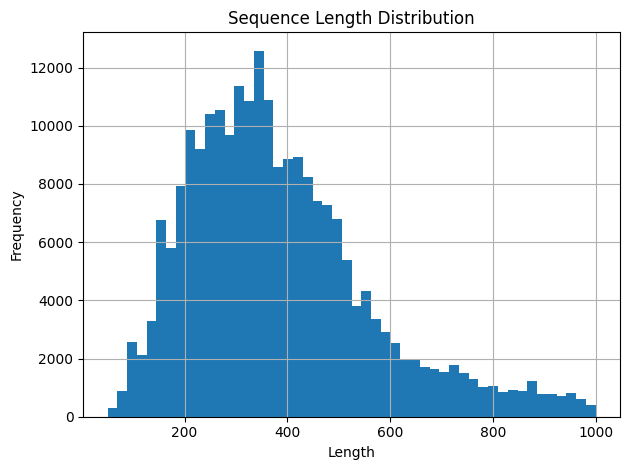

In [11]:
# Sequence length distribution
print("\nSequence length statistics:")
df['Sequence_Length'] = df['Sequence'].str.len()
print(df['Sequence_Length'].describe())

df['Sequence_Length'].hist(bins=50)
plt.title('Sequence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [12]:
def ec_number_distribution(df):
    """
    Analyze and visualize the distribution of proteins by EC number categories
    """    
    # Initialize counters
    single_ec = 0
    multi_ec_same_class = 0
    multi_ec_different_classes = 0
    
    # Store examples for each category
    examples = {
        'single_ec': [],
        'multi_ec_same_class': [],
        'multi_ec_different_classes': []
    }
    
    for idx, row in df.iterrows():
        ec_numbers = str(row['EC number']).split(';')
        
        if len(ec_numbers) == 1:
            single_ec += 1
            if len(examples['single_ec']) < 3:
                examples['single_ec'].append((row['Entry'], ec_numbers[0]))
        else:
            # Multiple EC numbers - check if same main class
            main_classes = set()
            for ec in ec_numbers:
                ec = ec.strip()
                if '.' in ec:
                    main_class = ec.split('.')[0]
                    main_classes.add(main_class)
            
            if len(main_classes) == 1:
                multi_ec_same_class += 1
                if len(examples['multi_ec_same_class']) < 3:
                    examples['multi_ec_same_class'].append((row['Entry'], ec_numbers, list(main_classes)))
            else:
                multi_ec_different_classes += 1
                if len(examples['multi_ec_different_classes']) < 3:
                    examples['multi_ec_different_classes'].append((row['Entry'], ec_numbers, list(main_classes)))
    
    # Calculate totals and percentages
    total_entries = len(df)
    categories = {
        'Single EC number': single_ec,
        'Multi-EC, same main class': multi_ec_same_class,
        'Multi-EC, different main classes': multi_ec_different_classes
    }
    
    percentages = {k: (v / total_entries) * 100 for k, v in categories.items()}
    
    return categories, percentages, examples, total_entries

def create_interactive_ec_distribution(categories, percentages):
    """Create an interactive pie chart using Plotly"""
    labels = list(categories.keys())
    sizes = list(categories.values())
    
    hover_text = [f'{label}<br>{count:,} entries<br>{percentages[label]:.2f}%' 
                 for label, count in categories.items()]
    
    fig = px.pie(values=sizes, names=labels, 
                 title='Distribution of Proteins by EC Number Categories',
                 hover_data=[hover_text],
                 color=labels,
                 color_discrete_map={
                     'Single EC number': '#66c2a5',
                     'Multi-EC, same main class': '#fc8d62', 
                     'Multi-EC, different main classes': '#8da0cb'
                 })
    
    fig.update_traces(textposition='inside', textinfo='percent',
                      hovertemplate='<b>%{label}</b><br>%{customdata[0]}<extra></extra>',
                      customdata=[[text] for text in hover_text])
    
    fig.update_layout(
        title_x=0.5,
        title_font_size=16,
        showlegend=True,
        legend=dict(orientation="v", yanchor="middle", y=0.5, xanchor="left", x=1.1),
        width=900,
        height=600
    )
    
    fig.show()

def print_detailed_statistics(categories, percentages, examples, total_entries):
    """Print detailed statistics about the EC number distribution"""
    print("\n" + "="*70)
    print("DETAILED EC NUMBER DISTRIBUTION STATISTICS")
    print("="*70)
    
    for category, count in categories.items():
        print(f"{category:<35}: {count:>7,} entries ({percentages[category]:>6.2f}%)")
    
    print(f"\n{'Total entries':<35}: {total_entries:>7,} entries (100.00%)")
    
    print("\n" + "="*70)
    print("EXAMPLES FOR EACH CATEGORY")
    print("="*70)
    
    print(f"\nSingle EC number examples:")
    for entry, ec in examples['single_ec']:
        print(f"  - {entry}: {ec}")
    
    print(f"\nMulti-EC, same main class examples:")
    for entry, ec_list, main_classes in examples['multi_ec_same_class']:
        print(f"  - {entry}: {ec_list} → Main class: {main_classes[0]}")
    
    print(f"\nMulti-EC, different main classes examples:")
    for entry, ec_list, main_classes in examples['multi_ec_different_classes']:
        print(f"  - {entry}: {ec_list} → Main classes: {main_classes}")

# Run the complete analysis
categories, percentages, examples, total_entries = ec_number_distribution(df)
create_interactive_ec_distribution(categories, percentages)
print_detailed_statistics(categories, percentages, examples, total_entries)


DETAILED EC NUMBER DISTRIBUTION STATISTICS
Single EC number                   : 212,054 entries ( 93.50%)
Multi-EC, same main class          :   9,443 entries (  4.16%)
Multi-EC, different main classes   :   5,302 entries (  2.34%)

Total entries                      : 226,799 entries (100.00%)

EXAMPLES FOR EACH CATEGORY

Single EC number examples:
  - A0A023I7E1: 3.2.1.39
  - A0A024RXP8: 3.2.1.91
  - A0A024SC78: 3.1.1.74

Multi-EC, same main class examples:
  - A0A009IHW8: ['3.2.2.-', ' 3.2.2.6'] → Main class: 3
  - A0A072VDF2: ['1.2.1.-', ' 1.2.1.44'] → Main class: 1
  - A0A075FBG7: ['4.2.3.131', ' 4.2.3.189', ' 4.2.3.190'] → Main class: 4

Multi-EC, different main classes examples:
  - A0A061I403: ['2.7.7.108', ' 3.1.4.-'] → Main classes: ['2', '3']
  - A0A0A7HFE1: ['2.7.7.-', ' 3.1.-.-'] → Main classes: ['2', '3']
  - A0A0H2WZ38: ['3.5.1.2', ' 6.3.5.13'] → Main classes: ['6', '3']


In [13]:
def multi_ec_different_classes(df):
    """Analyze entries with multiple EC numbers that have different main classes"""
    multi_ec_entries = []
    
    for idx, row in df.iterrows():
        ec_numbers = str(row['EC number']).split(';')
        
        if len(ec_numbers) > 1:
            main_classes = set()
            for ec in ec_numbers:
                ec = ec.strip()
                if '.' in ec:
                    main_class = ec.split('.')[0]
                    main_classes.add(main_class)
            
            if len(main_classes) > 1:
                multi_ec_entries.append({
                    'Entry': row['Entry'],
                    'EC_numbers': ec_numbers,
                    'main_classes': list(main_classes),
                    'num_main_classes': len(main_classes),
                    'sequence_length': len(str(row['Sequence']))
                })
    
    return multi_ec_entries

def create_interactive_multi_ec_plot(multi_ec_df):
    """Create interactive visualization using Plotly"""
    if multi_ec_df.empty:
        return
    
    main_class_combinations = []
    for _, row in multi_ec_df.iterrows():
        combo = '-'.join(sorted(row['main_classes']))
        main_class_combinations.append(combo)
    
    combo_counts = pd.Series(main_class_combinations).value_counts().reset_index()
    combo_counts.columns = ['combination', 'count']
    
    if len(combo_counts) > 0:
        fig = px.pie(combo_counts.head(10), values='count', names='combination',
                     title='Top 10 Main Class Combinations in Multi-EC Entries')
        fig.update_layout(width=600, height=600)
        fig.show()

# Run the multi-EC analysis
multi_ec_entries = multi_ec_different_classes(df)
if multi_ec_entries:
    multi_ec_df = pd.DataFrame(multi_ec_entries)
    create_interactive_multi_ec_plot(multi_ec_df)
else:
    print("No entries found with multiple EC numbers from different main classes.")

In [14]:
# Summary Table
print("=== MAIN CLASS DETAILED STATISTICS ===")
summary_data = []
for main_class in sorted(df['EC_Main_Class'].dropna().unique()):
    class_data = df[df['EC_Main_Class'] == main_class]
    class_display = get_ec_main_class_display(main_class)
    summary_data.append({
        'EC_Main_Class': int(main_class),
        'EC_Main_Class_Display': class_display,
        'Count': len(class_data),
        'Percentage': f"{len(class_data)/len(df)*100:.2f}%",
        'Avg_Sequence_Length': f"{class_data['Sequence_Length'].mean():.1f}",
        'Min_Sequence_Length': int(class_data['Sequence_Length'].min()),
        'Max_Sequence_Length': int(class_data['Sequence_Length'].max()),
        'Median_Sequence_Length': int(class_data['Sequence_Length'].median())
    })
summary_df = pd.DataFrame(summary_data)
print("\n=== COMPREHENSIVE SUMMARY TABLE ===")
print(summary_df.to_string(index=False))
print("\n=== DATA QUALITY SUMMARY ===")
print(f"Total entries: {len(df):,}")

=== MAIN CLASS DETAILED STATISTICS ===

=== COMPREHENSIVE SUMMARY TABLE ===
 EC_Main_Class EC_Main_Class_Display  Count Percentage Avg_Sequence_Length  Min_Sequence_Length  Max_Sequence_Length  Median_Sequence_Length
             1    1. Oxidoreductases  30546     13.47%               390.9                   50                 1000                     353
             2       2. Transferases  77586     34.21%               369.3                   50                 1000                     339
             3         3. Hydrolases  49475     21.81%               362.5                   50                 1000                     319
             4             4. Lyases  20201      8.91%               349.8                   53                  999                     331
             5         5. Isomerases  12886      5.68%               376.0                   52                  998                     358
             6            6. Ligases  23996     10.58%               502.1    

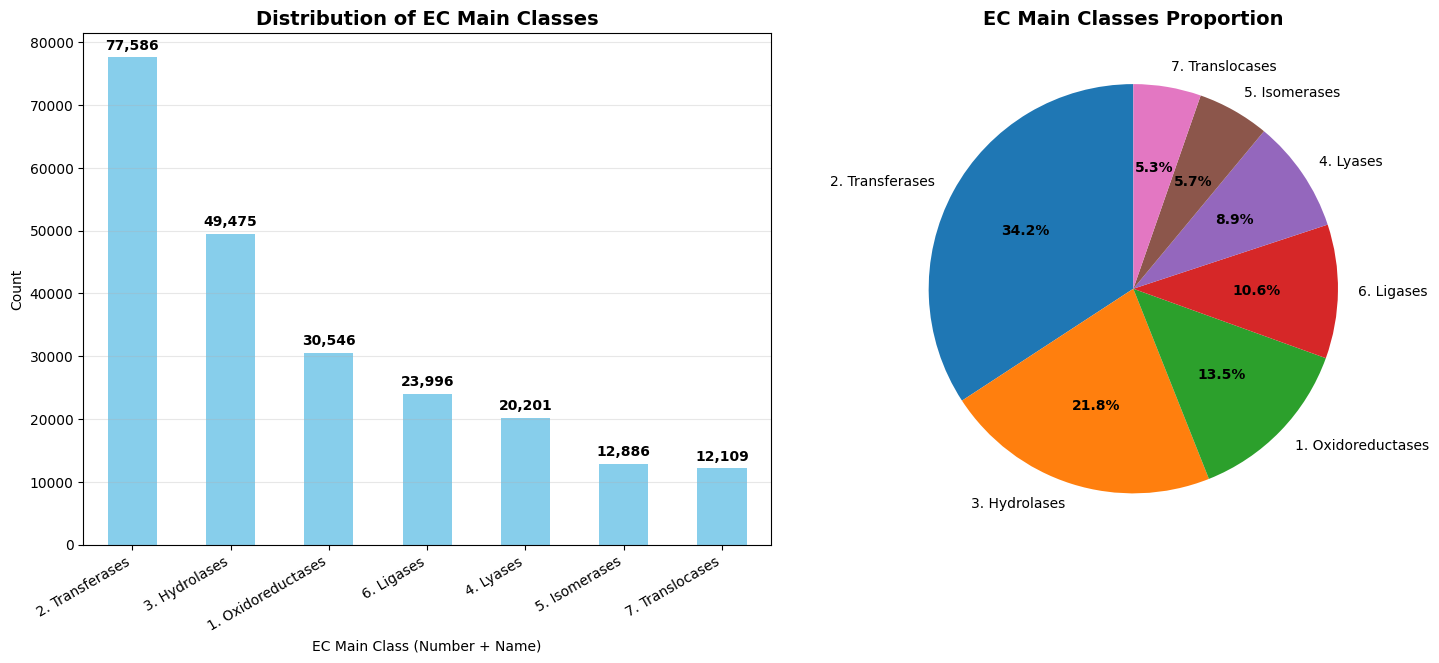

In [15]:
# EC Main Class Visualizations
main_class_dist = df['EC_Main_Class_Display'].value_counts()

plt.figure(figsize=(15, 12))

# Plot 1: Main class distribution bar chart
plt.subplot(2, 2, 1)
main_class_dist.plot(kind='bar', color='skyblue')
plt.title('Distribution of EC Main Classes', fontsize=14, fontweight='bold')
plt.xlabel('EC Main Class (Number + Name)')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(main_class_dist.values):
    plt.text(i, v + max(main_class_dist.values)*0.01, f'{v:,}', 
             ha='center', va='bottom', fontweight='bold')

# Plot 2: Pie chart
plt.subplot(2, 2, 2)
wedges, texts, autotexts = plt.pie(main_class_dist.values, 
                                   labels=main_class_dist.index, 
                                   autopct='%1.1f%%',
                                   startangle=90)
plt.title('EC Main Classes Proportion', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# Plot 3: Interactive sequence length by main class
valid_classes = df.dropna(subset=['EC_Main_Class_Display'])

fig = px.box(valid_classes, 
             x='EC_Main_Class_Name', 
             y='Sequence_Length',
             color='EC_Main_Class_Name',
             color_discrete_sequence=px.colors.qualitative.Set2,
             title='Sequence Length Distribution by EC Main Class',
             hover_data=['EC_Main_Class_Name'])

for i, class_name in enumerate(valid_classes['EC_Main_Class_Name'].unique()):
    count = len(valid_classes[valid_classes['EC_Main_Class_Name'] == class_name])
    mean_val = valid_classes[valid_classes['EC_Main_Class_Name'] == class_name]['Sequence_Length'].mean()
    
    fig.add_annotation(
        x=class_name,
        y=valid_classes[valid_classes['EC_Main_Class_Name'] == class_name]['Sequence_Length'].max() * 1.1,
        text=f"n={count}<br>mean={mean_val:.0f}",
        showarrow=False,
        font=dict(size=10, color="red")
    )

fig.update_layout(width=1000, height=600)
fig.show()

In [16]:
# Save cleaned data
cleaned_file = f"../{cfg['data']['paths']['raw']}/uniprot_cleaned.csv"
df.to_csv(cleaned_file, index=False)
print(f"\nCleaned data saved to: {cleaned_file}")


Cleaned data saved to: ../data/raw/uniprot_cleaned.csv


## 4. Class Balancing

In [17]:
# Convert main EC class numbers (1-7) into ML labels (0-6)
df['Label'] = df['EC_Main_Class'] - 1

# Drop rows with invalid labels
initial_count = len(df)
df = df.dropna(subset=['Label'])
df['Label'] = df['Label'].astype(int)

print(f"Extracted labels for {len(df):,} entries")
print(f"Dropped {initial_count - len(df):,} entries with invalid EC numbers")

Extracted labels for 226,799 entries
Dropped 0 entries with invalid EC numbers


In [18]:
# Check original class distribution and imbalance
print("\n=== ORIGINAL CLASS DISTRIBUTION ===")
class_counts = df['Label'].value_counts().sort_index()
for label, count in class_counts.items():
    print(f"Class {label}: {count:>8,} samples")

original_max = class_counts.max()
original_min = class_counts.min()
imbalance_ratio = original_max / original_min
print(f"\nOriginal imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"(Max class: {original_max:,} / Min class: {original_min:,})")


=== ORIGINAL CLASS DISTRIBUTION ===
Class 0:   30,546 samples
Class 1:   77,586 samples
Class 2:   49,475 samples
Class 3:   20,201 samples
Class 4:   12,886 samples
Class 5:   23,996 samples
Class 6:   12,109 samples

Original imbalance ratio: 6.41:1
(Max class: 77,586 / Min class: 12,109)


In [19]:
# Apply class balancing using config targets
print("\n=== BALANCING TARGETS FROM CONFIG ===")
print(f"Random seed: {random_seed}")
print("\nTarget samples per class:")
for label, target in targets.items():
    print(f"  Class {label}: {target:,} samples")

print("\n=== APPLYING CLASS BALANCING ===")
balanced_dfs = []

for label, target_count in targets.items():
    class_df = df[df['Label'] == label]
    current_count = len(class_df)
    
    if current_count == 0:
        print(f"Warning: No samples for class {label}")
        continue
    
    # Take minimum of available samples and target
    sample_count = min(current_count, target_count)
    
    # Random sampling with fixed seed for reproducibility
    sampled_df = class_df.sample(n=sample_count, random_state=random_seed)
    balanced_dfs.append(sampled_df)
    
    print(f"Class {label}: {current_count:>7,} → {sample_count:>7,}")

# Combine all balanced classes
df_balanced = pd.concat(balanced_dfs, ignore_index=True)

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=random_seed).reset_index(drop=True)

print(f"\n{'Total':<8} {len(df):>7,} → {len(df_balanced):>7,}")

# Check final imbalance
balanced_class_counts = df_balanced['Label'].value_counts().sort_index()
balanced_max = balanced_class_counts.max()
balanced_min = balanced_class_counts.min()
balanced_imbalance = balanced_max / balanced_min
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1 → {balanced_imbalance:.2f}:1")


=== BALANCING TARGETS FROM CONFIG ===
Random seed: 42

Target samples per class:
  Class 0: 30,000 samples
  Class 1: 30,000 samples
  Class 2: 30,000 samples
  Class 3: 30,000 samples
  Class 4: 30,000 samples
  Class 5: 30,000 samples
  Class 6: 30,000 samples

=== APPLYING CLASS BALANCING ===
Class 0:  30,546 →  30,000
Class 1:  77,586 →  30,000
Class 2:  49,475 →  30,000
Class 3:  20,201 →  20,201
Class 4:  12,886 →  12,886
Class 5:  23,996 →  23,996
Class 6:  12,109 →  12,109

Total    226,799 → 159,192

Imbalance ratio: 6.41:1 → 2.48:1


## 5. Train/Val/Test Split

In [ ]:
# Prepare data for splitting (only Sequence and Label columns)
df_final = df_balanced[['Sequence', 'Label']].copy()

print("=== DATASET READY FOR SPLITTING ===")
print(f"Total samples: {len(df_final):,}")
print(f"Features: Sequence")
print(f"Target: Label (0-{cfg['model']['num_labels']-1})")
print(f"\nSplit ratios from config:")
print(f"  Train: {cfg['data']['split']['train']*100:.0f}%")
print(f"  Val: {cfg['data']['split']['val']*100:.0f}%")
print(f"  Test: {cfg['data']['split']['test']*100:.0f}%")

=== DATASET READY FOR SPLITTING ===
Total samples: 159,192
Features: Sequence
Target: Label (0-6)

Split ratios from config:
  Train: 70%
  Val: 15%
  Test: 15%


In [21]:
print("\n=== PERFORMING STRATIFIED TRAIN/VAL/TEST SPLIT ===")

# Calculate split sizes from config
train_ratio = cfg['data']['split']['train']
val_ratio = cfg['data']['split']['val']
test_ratio = cfg['data']['split']['test']

# Verify splits sum to 1.0
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 0.001, "Split ratios must sum to 1.0"

# First split: train vs (val + test)
temp_size = val_ratio + test_ratio
train_df, temp_df = train_test_split(
    df_final,
    test_size=temp_size,
    random_state=random_seed,
    stratify=df_final['Label']
)

# Second split: split temp into val and test
# test_size relative to temp_df
val_test_ratio = test_ratio / temp_size
val_df, test_df = train_test_split(
    temp_df,
    test_size=val_test_ratio,
    random_state=random_seed,
    stratify=temp_df['Label']
)

print(f"Train: {len(train_df):>7,} ({len(train_df)/len(df_final)*100:.1f}%)")
print(f"Val:   {len(val_df):>7,} ({len(val_df)/len(df_final)*100:.1f}%)")
print(f"Test:  {len(test_df):>7,} ({len(test_df)/len(df_final)*100:.1f}%)")


=== PERFORMING STRATIFIED TRAIN/VAL/TEST SPLIT ===
Train: 111,434 (70.0%)
Val:    23,879 (15.0%)
Test:   23,879 (15.0%)


In [22]:
# Verify stratification - check class distribution in each split
print("\n=== CLASS DISTRIBUTION IN SPLITS ===")
print(f"{'Class':<7} {'Train':>8} {'Val':>8} {'Test':>8}")
print("-" * 35)

train_counts = train_df['Label'].value_counts().sort_index()
val_counts = val_df['Label'].value_counts().sort_index()
test_counts = test_df['Label'].value_counts().sort_index()

for label in range(7):
    train_c = train_counts.get(label, 0)
    val_c = val_counts.get(label, 0)
    test_c = test_counts.get(label, 0)
    print(f"{label:<7} {train_c:>8,} {val_c:>8,} {test_c:>8,}")

print("-" * 35)
print(f"{'Total':<7} {len(train_df):>8,} {len(val_df):>8,} {len(test_df):>8,}")


=== CLASS DISTRIBUTION IN SPLITS ===
Class      Train      Val     Test
-----------------------------------
0         21,000    4,500    4,500
1         21,000    4,500    4,500
2         21,000    4,500    4,500
3         14,141    3,030    3,030
4          9,020    1,933    1,933
5         16,797    3,599    3,600
6          8,476    1,817    1,816
-----------------------------------
Total    111,434   23,879   23,879


In [23]:
# Save processed datasets
processed_dir = f"../{cfg['data']['paths']['processed']}"
os.makedirs(processed_dir, exist_ok=True)

train_path = f"{processed_dir}/train.csv"
val_path = f"{processed_dir}/val.csv"
test_path = f"{processed_dir}/test.csv"

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print("\n=== SAVED PROCESSED DATASETS ===")
print(f"Train: {train_path}")
print(f"Val:   {val_path}")
print(f"Test:  {test_path}")

print("\n=== FINAL SUMMARY ===")
print(f"Total sequences: {len(train_df) + len(val_df) + len(test_df):,}")
print(f"Number of classes: {train_df['Label'].nunique()}")
print(f"Class balance ratio: {balanced_imbalance:.2f}:1")


=== SAVED PROCESSED DATASETS ===
Train: ../data/processed/train.csv
Val:   ../data/processed/val.csv
Test:  ../data/processed/test.csv

=== FINAL SUMMARY ===
Total sequences: 159,192
Number of classes: 7
Class balance ratio: 2.48:1


## 6. Tokenization

Tokenize sequences using ESM2 tokenizer and save as HuggingFace datasets.
This prepares the data for efficient loading during model training.

In [24]:
print("\n=== STARTING TOKENIZATION ===")

# Load the processed CSVs
processed_dir = f"../{cfg['data']['paths']['processed']}"
train_df = pd.read_csv(f"{processed_dir}/train.csv")
val_df   = pd.read_csv(f"{processed_dir}/val.csv")
test_df  = pd.read_csv(f"{processed_dir}/test.csv")

train_sequences = train_df["Sequence"].tolist()
val_sequences   = val_df["Sequence"].tolist()
test_sequences  = test_df["Sequence"].tolist()

train_labels = train_df["Label"].tolist()
val_labels   = val_df["Label"].tolist()
test_labels  = test_df["Label"].tolist()

# Load tokenizer
model_name = cfg['model']['name']
print(f"Loading tokenizer from {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("Tokenizing train set...")
train_tokenized = tokenizer(train_sequences, padding=True, truncation=True)

print("Tokenizing validation set...")
val_tokenized = tokenizer(val_sequences, padding=True, truncation=True)

print("Tokenizing test set...")
test_tokenized = tokenizer(test_sequences, padding=True, truncation=True)

# Create Hugging Face Datasets
train_dataset = Dataset.from_dict(train_tokenized).add_column("labels", train_labels)
val_dataset   = Dataset.from_dict(val_tokenized).add_column("labels", val_labels)
test_dataset  = Dataset.from_dict(test_tokenized).add_column("labels", test_labels)

# Save to disk
save_dir = f"../{cfg['data']['paths']['tokenized']}"
os.makedirs(save_dir, exist_ok=True)

print("\nSaving tokenized datasets...")
train_dataset.save_to_disk(f"{save_dir}/train_dataset")
val_dataset.save_to_disk(f"{save_dir}/val_dataset")
test_dataset.save_to_disk(f"{save_dir}/test_dataset")

print("\n=== SAVED TOKENIZED DATASETS ===")
print(f"Train: {save_dir}/train_dataset")
print(f"Val:   {save_dir}/val_dataset")
print(f"Test:  {save_dir}/test_dataset")

print("\n=== TOKENIZATION SUMMARY ===")
print(f"Train samples: {len(train_dataset):,}")
print(f"Val samples:   {len(val_dataset):,}")
print(f"Test samples:  {len(test_dataset):,}")

print("\nPipeline complete! Ready for model training.")


=== STARTING TOKENIZATION ===
Loading tokenizer from facebook/esm2_t12_35M_UR50D...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Tokenizing train set...
Tokenizing validation set...
Tokenizing test set...

Saving tokenized datasets...


Saving the dataset (0/2 shards):   0%|          | 0/111434 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23879 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/23879 [00:00<?, ? examples/s]


=== SAVED TOKENIZED DATASETS ===
Train: ../data/tokenized/train_dataset
Val:   ../data/tokenized/val_dataset
Test:  ../data/tokenized/test_dataset

=== TOKENIZATION SUMMARY ===
Train samples: 111,434
Val samples:   23,879
Test samples:  23,879

Pipeline complete! Ready for model training.
